In [5]:
import wrf
import cartopy.crs as ccrs
import netCDF4 as nc
import glob
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pyart
import zipfile
import datetime as dt
import os
import tqdm
import pandas as pd
import warnings
warnings.simplefilter("ignore")
from metpy.interpolate import cross_section
  
def read_grid(t):
    path1 = "/g/data/w40/ab4502/IN2023_V06/data/radar/opol/grids/opol_"
    path2 = "_grids.nc"    
    grid = pyart.io.read_grid(path1+t+path2)#.to_xarray()
    #obs_lon, obs_lat = np.meshgrid(grid.lon.values,grid.lat.values)
    return grid#,obs_lon,obs_lat

def read_swirl(t,step=10,z=1500):
    path = "/g/data/w40/ab4502/IN2023_V06/data/radar/510/20231016/510_20231016_"
    swirl = xr.open_dataset(path+t+".nc")
    mask = swirl.retrieval_mask.sel(z=z)
    u = swirl.vx.sel(z=z)
    v = swirl.vy.sel(z=z)
    u = xr.where(mask==0,np.nan,u)
    v = xr.where(mask==0,np.nan,v)
    u = u.isel(y=range(0,swirl.y.shape[0],step),x=range(0,swirl.x.shape[0],step))
    v = v.isel(y=range(0,swirl.y.shape[0],step),x=range(0,swirl.x.shape[0],step))
    lon = swirl.longitude.isel(y=range(0,swirl.y.shape[0],step),x=range(0,swirl.x.shape[0],step))
    lat = swirl.latitude.isel(y=range(0,swirl.y.shape[0],step),x=range(0,swirl.x.shape[0],step))    
    return lon,lat,u,v

def read_swirl_3d(t):
    path = "/g/data/w40/ab4502/IN2023_V06/data/radar/510/20231016/510_20231016_"
    swirl = xr.open_dataset(path+t+".nc")
    mask = swirl.retrieval_mask
    u = swirl.vx
    v = swirl.vy
    w = swirl.vz
    u = xr.where(mask==0,np.nan,u)
    v = xr.where(mask==0,np.nan,v)
    w = xr.where(mask==0,np.nan,w)    
    return u,v,w

def get_xlabs(cross):
    lon_str = cross.lon.values.round(2).astype(str)
    lat_str = cross.lat.values.round(2).astype(str)
    xlab = [i + ", " + j for i, j in zip(lat_str,lon_str)]
    return xlab

def latlon_dist(lat, lon, lats, lons):

        #Calculate great circle distance (Harversine) between a lat lon point (lat, lon) and a list of lat lon
        # points (lats, lons)

        R = 6373.0

        lat1 = np.deg2rad(lat)
        lon1 = np.deg2rad(lon)
        lat2 = np.deg2rad(lats)
        lon2 = np.deg2rad(lons)

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        return (R * c)

def set_km_tick_labels(ax,cross,lats,lons):
    
    xy_lats = cross.lat.values#[xy.lat for xy in cross.xy_loc.values]
    xy_lons = cross.lon.values#[xy.lon for xy in cross.xy_loc.values]
    xy_xticklabs = np.round(latlon_dist(lats[0],lons[0],xy_lats,xy_lons),1).astype(str)
    tick_number = np.floor(cross.index.shape[0] / 8).astype(int)
    ax.set_xticks(np.arange(0,cross.index.shape[0],tick_number),xy_xticklabs[np.arange(0,cross.index.shape[0],tick_number)],rotation=0)
    ax.set_xlabel("Along-transect distance (km)")
    
def set_km_tick_labels_wrf(ax,cross,lats,lons):
    
    xy_lats = [xy.lat for xy in cross.xy_loc.values]
    xy_lons = [xy.lon for xy in cross.xy_loc.values]
    xy_xticklabs = np.round(latlon_dist(lats[0],lons[0],xy_lats,xy_lons),1).astype(str)
    tick_number = np.floor(cross.cross_line_idx.shape[0] / 8).astype(int)
    ax.set_xticks(np.arange(0,cross.cross_line_idx.shape[0],tick_number),xy_xticklabs[np.arange(0,cross.cross_line_idx.shape[0],tick_number)],rotation=0)
    ax.set_xlabel("Along-transect distance (km)")
    
def get_swirl_transect(t,transect_lat,transect_lon,mean_motion_top):

    steps=40

    radar_u3d,radar_v3d,radar_w3d = read_swirl_3d(t)

    u_cross=cross_section(radar_u3d.assign_coords(
        x=radar.to_xarray().lon,y=radar.to_xarray().lat).metpy.assign_crs(
        grid_mapping_name='latitude_longitude',
        earth_radius=6371229.0
    ),[transect_lat[0],transect_lon[0]],[transect_lat[1],transect_lon[1]],steps=steps)

    v_cross=cross_section(radar_v3d.assign_coords(
        x=radar.to_xarray().lon,y=radar.to_xarray().lat).metpy.assign_crs(
        grid_mapping_name='latitude_longitude',
        earth_radius=6371229.0
    ),[transect_lat[0],transect_lon[0]],[transect_lat[1],transect_lon[1]],steps=steps)

    w_cross=cross_section(radar_w3d.assign_coords(
        x=radar.to_xarray().lon,y=radar.to_xarray().lat).metpy.assign_crs(
        grid_mapping_name='latitude_longitude',
        earth_radius=6371229.0
    ),[transect_lat[0],transect_lon[0]],[transect_lat[1],transect_lon[1]],steps=steps)

    y1=transect_lat[0]; y2=transect_lat[1]
    x1=transect_lon[0]; x2=transect_lon[1]
    angle = np.arctan2((x2-x1),(y2-y1))
    uu_cross = np.cos(angle) * u_cross + np.sin(angle) * v_cross
    vv_cross = (-np.sin(angle) * u_cross) + np.cos(angle) * v_cross    

    wind_transect = xr.Dataset({"uu":uu_cross,"w":w_cross}).assign_coords({"index":np.arange(uu_cross.shape[1])})
    umean = wind_transect.sel({"z":slice(0,mean_motion_top)}).uu.mean()
    wind_transect["uu"] = wind_transect.uu - umean
    
    return wind_transect, uu_cross, vv_cross

def get_wrf_transects(t, transect_lons, transect_lats, mean_motion_top):

    wrflist = nc.Dataset("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead/highres_d04_"+t)
    t_ind=0

    heights = wrf.getvar(wrflist,"z",timeidx=t_ind)

    U = wrf.getvar(wrflist,"U",timeidx=t_ind)
    V = wrf.getvar(wrflist,"V",timeidx=t_ind)
    W = wrf.destagger(wrf.getvar(wrflist,"W",timeidx=t_ind),0,meta=True)
    dbz = wrf.getvar(wrflist,"dbz",timeidx=t_ind).persist().squeeze()

    start_point = wrf.CoordPair(lat=transect_lats[0],lon=transect_lons[0])
    end_point = wrf.CoordPair(lat=transect_lats[1],lon=transect_lons[1])
    y1=transect_lats[0]; y2=transect_lats[1]
    x1=transect_lons[0]; x2=transect_lons[1]
    angle = np.arctan2((x2-x1),(y2-y1))

    top = 12000
    #levels = np.linspace(0,top,100)
    levels = [50, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000]

    u_cross = wrf.vertcross(U,heights,wrfin=wrflist,levels=levels,start_point=start_point,end_point=end_point)
    v_cross = wrf.vertcross(V,heights,wrfin=wrflist,levels=levels,start_point=start_point,end_point=end_point)
    w_cross = wrf.vertcross(W,heights,wrfin=wrflist,levels=levels,start_point=start_point,end_point=end_point)
    refl_cross = wrf.vertcross(dbz,heights,wrfin=wrflist,levels=levels,start_point=start_point,end_point=end_point,latlon=True)

    uu_cross = np.cos(angle) * u_cross + np.sin(angle) * v_cross
    vv_cross = (-np.sin(angle) * u_cross) + np.cos(angle) * v_cross        
    
    wind_transect = xr.Dataset({"uu":uu_cross,"w":w_cross}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])})
    umean = wind_transect.sel({"vertical":slice(0,mean_motion_top)}).uu.mean()
    wind_transect["uu"] = wind_transect.uu - umean
    
    return wind_transect, uu_cross, vv_cross, refl_cross

def set_km_tick_labels_wrf(ax,cross,lats,lons):
    
    xy_lats = [xy.lat for xy in cross.xy_loc.values]
    xy_lons = [xy.lon for xy in cross.xy_loc.values]
    xy_xticklabs = np.round(latlon_dist(lats[0],lons[0],xy_lats,xy_lons),1).astype(str)
    tick_number = np.floor(cross.cross_line_idx.shape[0] / 8).astype(int)
    ax.set_xticks(np.arange(0,cross.cross_line_idx.shape[0],tick_number),xy_xticklabs[np.arange(0,cross.cross_line_idx.shape[0],tick_number)],rotation=0)
    ax.set_xlabel("Along-transect distance (km)")

def load_transect(tpath,t_fname,hpath,h_fname,mean_motion_top):

    ctrl = xr.open_dataset(tpath + t_fname)
    ctrl_highres = xr.open_dataset(hpath + h_fname, decode_times=False)
    ctrl["system_relative_along_transect_wind"] = ctrl["along_transect_wind"] - ctrl["along_transect_wind"].sel(vertical=slice(0,mean_motion_top)).\
                        mean(("vertical","cross_line_idx"))
    
    return ctrl.assign_coords({"transect":ctrl.transect}), ctrl_highres

def plot_transect_map(ctrl, ctrl_highres):
    
    
    plt.figure()
    ctrl_tstart = [ctrl.transect_starts_lon,ctrl.transect_starts_lat]
    ctrl_tend = [ctrl.transect_ends_lon,ctrl.transect_ends_lat]
    
    
    ax=plt.axes(projection=ccrs.PlateCarree())
    for i in range(len(ctrl.transect)):
        plt.plot([ctrl_tstart[0][i],ctrl_tend[0][i]], [ctrl_tstart[1][i],ctrl_tend[1][i]], color="grey", ls="--")
        plt.text(ctrl_tend[0][i], ctrl_tend[1][i], str(i), color="k", fontdict={"weight":"bold"})
    extents = ax.get_extent()

    ctrl_highres.REFL_10CM.squeeze().max("bottom_top").plot(x="XLONG",y="XLAT",cmap=pyart.graph.cm_colorblind.HomeyerRainbow,levels=np.linspace(0,70,11))
    ctrl_highres.isel(Time=0,west_east=slice(0,-1,10),south_north=slice(0,-1,10)).plot.quiver("XLONG","XLAT","U10","V10",scale=300,width=0.003)

    # ylim = ctrl.line_ylim
    # xlim = ctrl.line_xlim
    xlim = [np.concatenate([ctrl.transect_starts_lon,ctrl.transect_ends_lon]).min()-0.1,
            np.concatenate([ctrl.transect_starts_lon,ctrl.transect_ends_lon]).max()+0.1]
    ylim = [np.concatenate([ctrl.transect_starts_lat,ctrl.transect_ends_lat]).min()-0.1,
            np.concatenate([ctrl.transect_starts_lat,ctrl.transect_ends_lat]).max() + 0.1]    
    #ax.set_ylim(ylim)
    #ax.set_xlim(xlim)
    ax.set_ylim([-37,-35.5])
    ax.set_xlim([153,155])    
    ax.gridlines(draw_labels=["bottom","left"], ls=":")
    
    ax.set_title(ctrl.Time.values)

In [6]:
#Load OPOL and SWIRL grid
radar = read_grid("20231016_032400")
radar_lon,radar_lat,radar_u,radar_v = read_swirl("0324",z=500,step=1)
radar_lon_q,radar_lat_q,radar_u_q,radar_v_q = read_swirl("0324",z=500,step=6)

In [7]:
#Set up radar transects
radar_transect_lon1 = np.array([153.9,154.4])
radar_transect_lat1 = np.array([-36.15,-35.87])

radar_transect_lons = []
radar_transect_lats = []
#for i in np.arange(-0.025,0.275,0.025):
for i in np.arange(-0.3,0.45,0.025):
    radar_transect_lons.append(radar_transect_lon1 + i)
    radar_transect_lats.append(radar_transect_lat1 - i)
print(len(radar_transect_lons)," transects")

30  transects


(-37.0, -35.5)

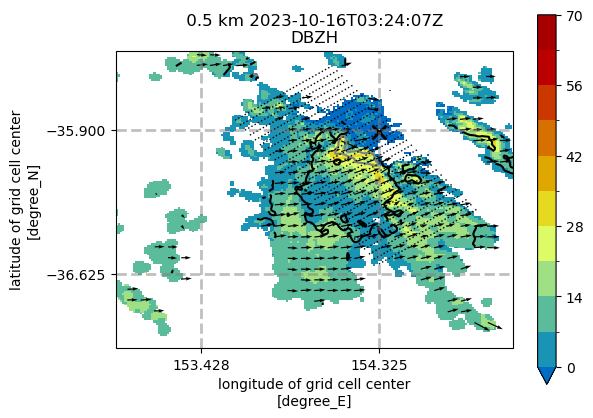

In [8]:
#Plot radar transects

ax=plt.axes(projection=ccrs.PlateCarree())
disp=pyart.graph.GridMapDisplay(radar)
disp.plot_grid("DBZH",level=1, ax=ax, levels=np.linspace(0,70,11))

lons = [153.6,154.6]
lats = [-36.6,-35.6]
ax.set_extent([lons[0],lons[1],lats[0],lats[1]])
ax.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)

ax.quiver(radar_lon_q,radar_lat_q,radar_u_q,radar_v_q,scale=500,width=0.003)
ax.contour(radar_lon, radar_lat, np.sqrt(radar_u**2+radar_v**2), levels=[15,20], colors=["k","grey"])

for i in range(len(radar_transect_lons)):
    ax.plot(radar_transect_lons[i],radar_transect_lats[i],color="k",lw=1, ls=":")
    
ax.set_xlim([153,155])
ax.set_ylim([-37,-35.5])

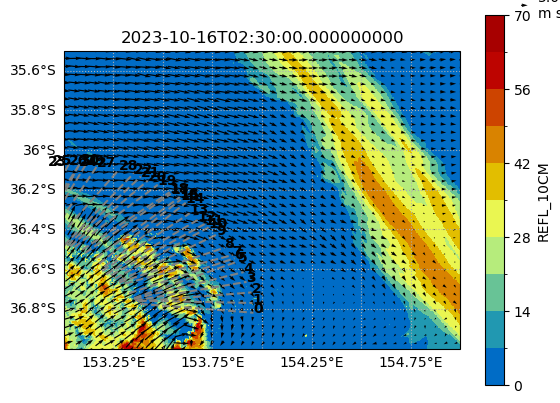

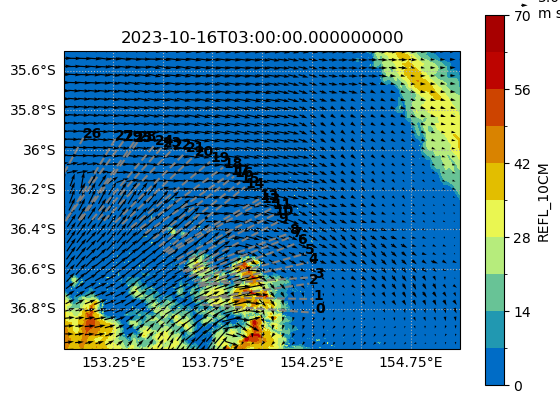

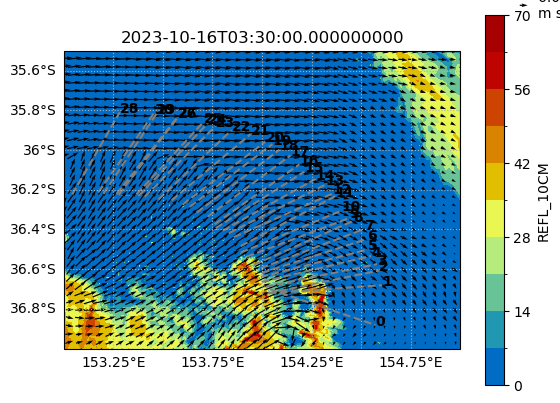

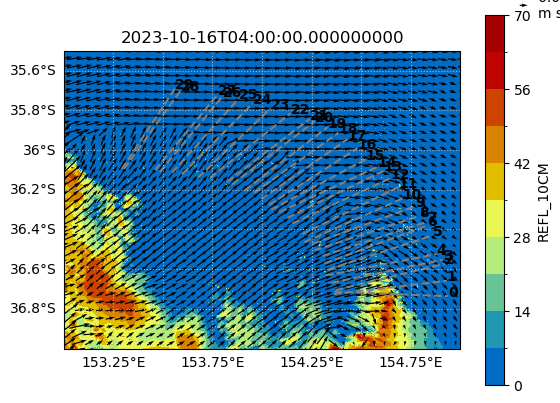

In [9]:
#Load and plot WRF transects

tpath = "/g/data/w40/ab4502/WRF_simulations/transects/"
hpath = "/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead/"
mean_motion_top = 6000

t_fname = ["tasman_d04_20231015_20231016_ramssa_shortlead_02:30:00.nc",
           "tasman_d04_20231015_20231016_ramssa_shortlead_03:00:00.nc",
           "tasman_d04_20231015_20231016_ramssa_shortlead_03:30:00.nc",
           "tasman_d04_20231015_20231016_ramssa_shortlead_04:00:00.nc"]
h_fname = ["highres_d04_2023-10-16_02:30:00",
           "highres_d04_2023-10-16_03:00:00",
           "highres_d04_2023-10-16_03:30:00",
           "highres_d04_2023-10-16_04:00:00"]
ctrl_list = []

for t, h in zip(t_fname,h_fname):
    ctrl, ctrl_highres = load_transect(tpath,t,hpath,h,mean_motion_top)
    plot_transect_map(ctrl, ctrl_highres)
    ctrl_list.append(ctrl)

In [10]:
# radar_crosses = []
# for lat, lon in zip(radar_transect_lats,radar_transect_lats):
#     steps=50
#     radar_crosses.append(
#         cross_section(radar.to_xarray().isel({"time":0}).DBZH.assign_coords(
#         x=radar.to_xarray().lon,y=radar.to_xarray().lat).metpy.assign_crs(
#         grid_mapping_name='latitude_longitude',
#         earth_radius=6371229.0
#     ),[lat[0],lon[0]],[lat[1],lon[1]],steps=steps)
#     )


#Compute radar cross sections
radar_crosses = []
swirl_winds = []
swirl_uu = []
swirl_vv = []
for lat, lon in tqdm.tqdm(zip(radar_transect_lats,radar_transect_lons)):
    steps=50
    radar_crosses.append(
        cross_section(radar.to_xarray().isel({"time":0}).assign_coords(
        x=radar.to_xarray().lon,y=radar.to_xarray().lat).metpy.assign_crs(
        grid_mapping_name='latitude_longitude',
        earth_radius=6371229.0
    ),[lat[0],lon[0]],[lat[1],lon[1]],steps=steps).DBZH
    )
    
    wind, uu, vv = get_swirl_transect("0324",lat,lon,6000)
    swirl_winds.append(wind)
    swirl_uu.append(uu)
    swirl_vv.append(vv)    
    
radar_crosses = xr.concat(radar_crosses,"transect")    
swirl_uu = xr.concat(swirl_uu,"transect")
swirl_vv = xr.concat(swirl_vv,"transect")
swirl_wind = xr.concat(swirl_winds,"transect")

30it [00:47,  1.58s/it]


In [11]:
# #Get radar and WRF transects

# steps=50
# radar_cross1=cross_section(radar.to_xarray().isel({"time":0}).DBZH.assign_coords(
#     x=radar.to_xarray().lon,y=radar.to_xarray().lat).metpy.assign_crs(
#     grid_mapping_name='latitude_longitude',
#     earth_radius=6371229.0
# ),[radar_transect_lat1[0],radar_transect_lon1[0]],[radar_transect_lat1[1],radar_transect_lon1[1]],steps=steps)

# steps=40
# radar_cross2=cross_section(radar.to_xarray().isel({"time":0}).DBZH.assign_coords(
#     x=radar.to_xarray().lon,y=radar.to_xarray().lat).metpy.assign_crs(
#     grid_mapping_name='latitude_longitude',
#     earth_radius=6371229.0
# ),[radar_transect_lat2[0],radar_transect_lon2[0]],[radar_transect_lat2[1],radar_transect_lon2[1]],steps=steps)

# mean_motion_top=6000
# swirl_wind_transect1, swirl_uu_cross1, swirl_vv_cross1 = get_swirl_transect("0324",radar_transect_lat1,radar_transect_lon1,mean_motion_top)    
# swirl_wind_transect2, swirl_uu_cross2, swirl_vv_cross2 = get_swirl_transect("0324",radar_transect_lat2,radar_transect_lon2,mean_motion_top)    

# wrf_wind_transect, wrf_uu_cross, wrf_vv_cross, wrf_refl_cross = get_wrf_transects("2023-10-16_03:30:00", wrf_transect_lons, wrf_transect_lats, mean_motion_top)

Text(0.5, 0, 'Along-transect distance (km)')

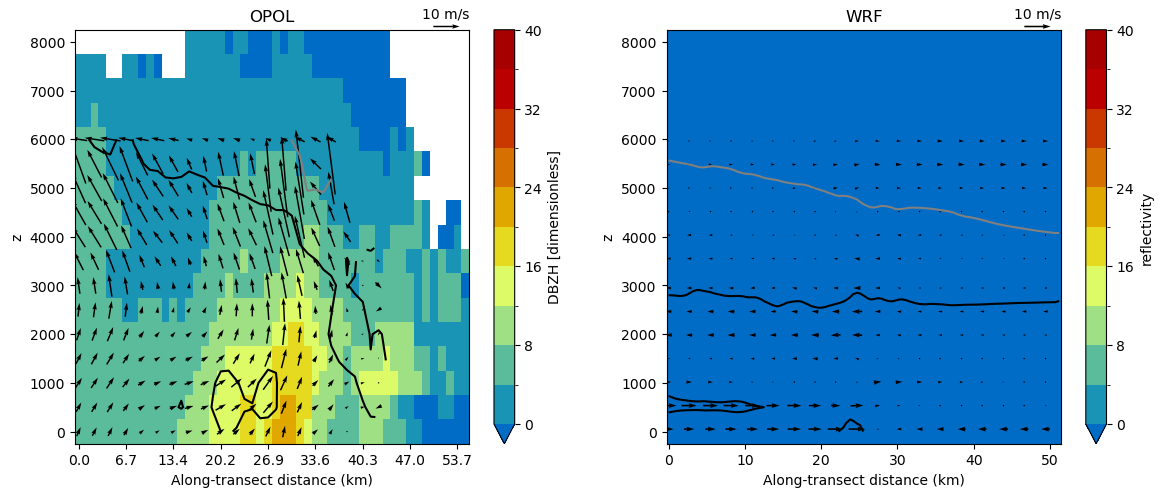

In [12]:
y2=8000
wrf_t = 1
wrf_transects = ctrl_list[wrf_t].transect.shape[0]

plt.figure(figsize=[14,6])
plt.subplot(1,2,1)
plt.subplots_adjust(top=0.8)
radar_crosses.median("transect").sel(z=slice(0,y2)).\
    plot(cmap=pyart.graph.cm_colorblind.HomeyerRainbow,levels=np.linspace(0,40,11))
wnd_plot = swirl_wind.mean("transect").isel(index=slice(0,-1,2)).plot.quiver("index","z","uu","w",scale=150)
xr.plot.contour(np.sqrt(swirl_uu**2 + swirl_vv**2).mean("transect"),colors=["k","grey"],levels=[15,20],linewidths=1.5)
plt.title("OPOL")
qv_key = plt.gca().quiverkey(wnd_plot, 0.94,1.01,10,r'10 m/s',labelpos='N', labelsep =0.05, 
                      color='k')
set_km_tick_labels(plt.gca(),radar_crosses[0],radar_transect_lats[0],radar_transect_lons[0])

plt.subplot(1,2,2)
ctrl_list[wrf_t].sel(transect=(slice(0,wrf_transects))).reflectivity.median("transect").sel(vertical=radar_crosses.sel(z=slice(0,y2)).z,method="nearest").\
    plot(cmap=pyart.graph.cm_colorblind.HomeyerRainbow,levels=np.linspace(0,40,11))
wnd_plot = ctrl_list[wrf_t].sel(transect=(slice(0,wrf_transects))).sel(vertical=swirl_wind.sel(z=slice(0,y2)).z,method="nearest").isel(cross_line_idx=slice(0,-1,6)).mean("transect").\
    plot.quiver("cross_line_idx","vertical","system_relative_along_transect_wind","w",width=0.004,scale=150)
xr.plot.contour(ctrl_list[wrf_t].sel(transect=(slice(0,wrf_transects))).mean("transect").sel(vertical=swirl_wind.sel(z=slice(0,y2)).z,method="nearest").ground_rel_ws,colors=["k","grey"],levels=[15,20],linewidths=1.5)
plt.title("WRF")
qv_key = plt.gca().quiverkey(wnd_plot, 0.94,1.01,10,r'10 m/s',labelpos='N', labelsep =0.05, 
                      color='k')
plt.gca().set_xlabel("Along-transect distance (km)")


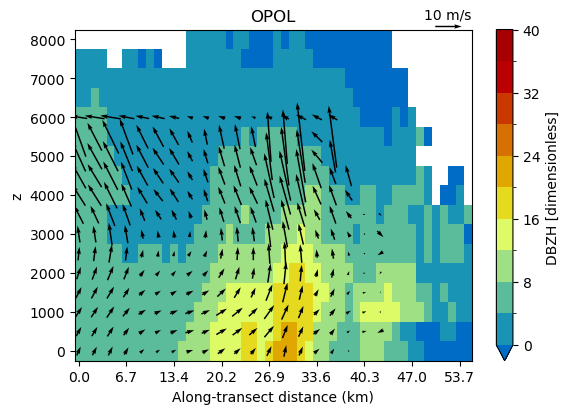

In [17]:
plt.subplots_adjust(top=0.8)
radar_crosses.median("transect").sel(z=slice(0,y2)).\
    plot(cmap=pyart.graph.cm_colorblind.HomeyerRainbow,levels=np.linspace(0,40,11))
wnd_plot = swirl_wind.mean("transect").isel(index=slice(0,-1,2)).plot.quiver("index","z","uu","w",scale=150)
plt.title("OPOL")
qv_key = plt.gca().quiverkey(wnd_plot, 0.94,1.01,10,r'10 m/s',labelpos='N', labelsep =0.05, 
                      color='k')
set_km_tick_labels(plt.gca(),radar_crosses[0],radar_transect_lats[0],radar_transect_lons[0])

Text(0.5, 0, 'Along-transect distance (km)')

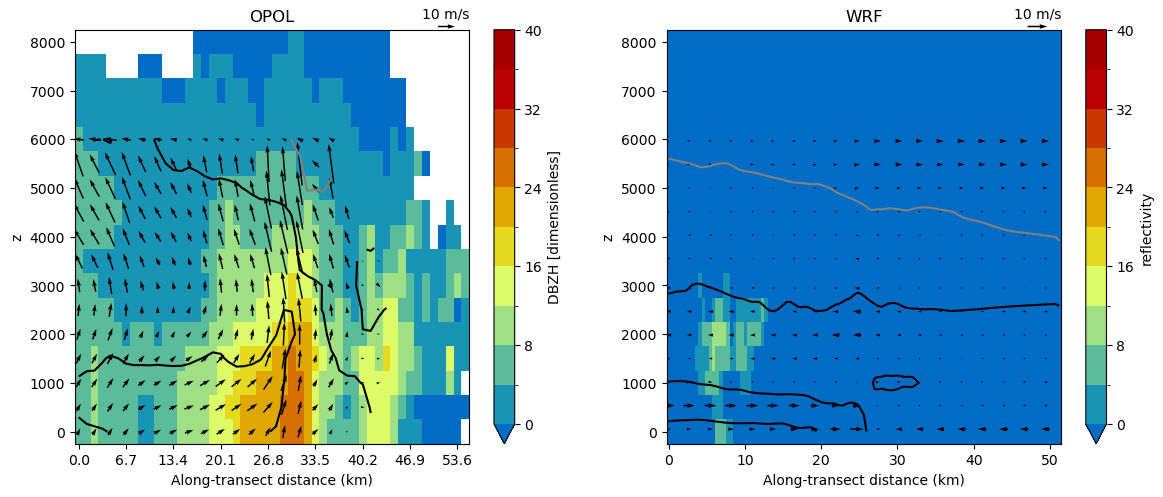

In [77]:
y2=8000
wrf_t = 1
wrf_transects = ctrl_list[wrf_t].transect.shape[0]

plt.figure(figsize=[14,6])
plt.subplot(1,2,1)
plt.subplots_adjust(top=0.8)
radar_crosses.median("transect").sel(z=slice(0,y2)).\
    plot(cmap=pyart.graph.cm_colorblind.HomeyerRainbow,levels=np.linspace(0,40,11))
wnd_plot = swirl_wind.mean("transect").isel(index=slice(0,-1,2)).plot.quiver("index","z","uu","w")
xr.plot.contour(np.sqrt(swirl_uu**2 + swirl_vv**2).mean("transect"),colors=["k","grey"],levels=[15,20],linewidths=1.5)
plt.title("OPOL")
qv_key = plt.gca().quiverkey(wnd_plot, 0.94,1.01,10,r'10 m/s',labelpos='N', labelsep =0.05, 
                      color='k')
set_km_tick_labels(plt.gca(),radar_crosses[0],radar_transect_lats[0],radar_transect_lons[0])

plt.subplot(1,2,2)
ctrl_list[wrf_t].sel(transect=(slice(0,wrf_transects))).reflectivity.median("transect").sel(vertical=radar_crosses.sel(z=slice(0,y2)).z,method="nearest").\
    plot(cmap=pyart.graph.cm_colorblind.HomeyerRainbow,levels=np.linspace(0,40,11))
wnd_plot = ctrl_list[wrf_t].sel(transect=(slice(0,wrf_transects))).sel(vertical=swirl_wind.sel(z=slice(0,y2)).z,method="nearest").isel(cross_line_idx=slice(0,-1,6)).mean("transect").\
    plot.quiver("cross_line_idx","vertical","system_relative_along_transect_wind","w",width=0.004,scale=200)
xr.plot.contour(ctrl_list[wrf_t].sel(transect=(slice(0,wrf_transects))).mean("transect").sel(vertical=swirl_wind.sel(z=slice(0,y2)).z,method="nearest").ground_rel_ws,colors=["k","grey"],levels=[15,20],linewidths=1.5)
plt.title("WRF")
qv_key = plt.gca().quiverkey(wnd_plot, 0.94,1.01,10,r'10 m/s',labelpos='N', labelsep =0.05, 
                      color='k')
plt.gca().set_xlabel("Along-transect distance (km)")


In [ ]:
## y2=8000
# width=0.004
# scale=200

# #PLOT SWIRL
# plt.figure(figsize=[14,6])
# plt.subplot(1,2,1)

# c=xr.plot.pcolormesh(radar_cross1,
#     vmin=0, 
#     vmax=50,
#     cmap=pyart.graph.cm_colorblind.HomeyerRainbow,levels=11,add_colorbar=False,extend="max")
# wnd_plot=swirl_wind_transect1\
#         .coarsen(dim={"index":3,"z":1},boundary="trim").mean()\
#         .plot.quiver(x="index",y="z",u="uu",v="w",scale=scale,width=width,add_guide = False)
# qv_key = plt.gca().quiverkey(wnd_plot, 0.94,1.02,5,r'5 m/s',labelpos='N', labelsep =0.05, 
#                       color='k')
# xr.plot.contour(np.sqrt(((swirl_uu_cross1**2) + (swirl_vv_cross1**2))),colors=["k","grey"],levels=[15,20],linewidths=1.5)

# plt.ylim([-100,y2])
# set_km_tick_labels(plt.gca(),radar_cross1,radar_transect_lat1,radar_transect_lon1)
# plt.gca().grid(ls="--",color="gray",alpha=0.5)
# plt.ylabel("Height above ground (m)")
# plt.title("OPOL wind retrieval")

# #Plot WRF

# plt.subplot(1,2,2)
# x_step=15
# vert_step=1
# c=xr.plot.pcolormesh(wrf_refl_cross,
#     vmin=0, 
#     vmax=50,
#     cmap=pyart.graph.cm_colorblind.HomeyerRainbow,levels=11,add_colorbar=False,extend="max")
# wnd_plot=wrf_wind_transect.drop_vars("xy_loc")\
#         .coarsen(dim={"cross_line_idx":x_step,"vertical":vert_step},boundary="trim").mean()\
#         .plot.quiver(x="cross_line_idx",y="vertical",u="uu",v="w",scale=scale,width=width,add_guide = False)
# qv_key = plt.gca().quiverkey(wnd_plot, 0.94,1.02,5,r'5 m/s',labelpos='N', labelsep =0.05, 
#                       color='k')
# xr.plot.contour(np.sqrt(((wrf_uu_cross**2) + (wrf_vv_cross**2))),colors=["k","grey"],levels=[15,20],linewidths=1.5)
# plt.ylim([0,y2])
# set_km_tick_labels_wrf(plt.gca(),wrf_refl_cross,wrf_transect_lats,wrf_transect_lons)
# plt.gca().grid(ls="--",color="gray",alpha=0.5)
# plt.ylabel("")
# plt.title("WRF 0.44 km domain")

# cb=plt.colorbar(c,cax=plt.axes([0.3,0.005,0.4,0.02]),orientation="horizontal")
# cb.set_label("dBZ")


# plt.savefig("/g/data/w40/ab4502/IN2023_V06/figs/reflectivity_cross_section.jpeg",dpi=400,bbox_inches="tight")